# 🕐 Bollinger Bands - Test Delay di Esecuzione

## 📋 Obiettivo del Test
Confrontare l'effetto di diversi delay di esecuzione sulla performance della strategia Bollinger Bands:

### ⏱️ **Configurazioni di Test**
1. **Immediata** (~0 secondi): Primo tick disponibile dopo signal
2. **30 secondi**: Aspetta almeno 30 secondi dopo signal prima di eseguire
3. **45 secondi**: Aspetta almeno 45 secondi dopo signal prima di eseguire

### 🎯 **Ipotesi da Testare**
- **Spread più bassi**: I delay potrebbero permettere al mercato di stabilizzarsi
- **Migliore execution**: Prezzo più favorevole dopo la volatilità iniziale
- **Trade-off**: Possibile perdita di momentum vs. migliore pricing

### 🔧 **Implementazione**
- **Zero Lookahead Bias**: Manteniamo la logica bias-free
- **Mapping Accurato**: Timestamp mapping preciso per ogni delay
- **Grid Search**: Stessi parametri per confronto equo
- **Analisi Comparativa**: Heatmaps e performance metrics a confronto

In [2]:
# ===============================================================================
# 📦 DEPENDENCIES AND SETUP
# ===============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from numba import jit
import warnings
from datetime import datetime

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Display startup info
print("✅ All libraries imported successfully")
print(f"🚀 Execution delay test started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 Numba JIT compilation: Ready")
print(f"📊 Matplotlib backend: {plt.get_backend()}")
print("="*80)

✅ All libraries imported successfully
🚀 Execution delay test started: 2025-06-24 15:37:27
🔧 Numba JIT compilation: Ready
📊 Matplotlib backend: inline


In [3]:
# ===============================================================================
# 📊 DATA LOADING AND PREPARATION
# ===============================================================================

print("📊 Loading tick data...")
start_time = time.time()

# Load and validate tick data
TICK_DATA_PATH = '/home/edocame/Desktop/data_python/tick_lastmonth.csv'

try:
    tick_df = pd.read_csv(TICK_DATA_PATH)
    tick_df['timestamp'] = pd.to_datetime(tick_df['timestamp'])
    tick_df = tick_df.sort_values('timestamp').reset_index(drop=True)
    
    # Validate data integrity
    required_columns = ['timestamp', 'askPrice', 'bidPrice']
    missing_cols = [col for col in required_columns if col not in tick_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Check for invalid prices
    invalid_prices = (tick_df['askPrice'] <= 0) | (tick_df['bidPrice'] <= 0) | \
                    (tick_df['askPrice'] < tick_df['bidPrice'])
    if invalid_prices.any():
        print(f"⚠️  Found {invalid_prices.sum()} invalid price records - cleaning...")
        tick_df = tick_df[~invalid_prices].reset_index(drop=True)
    
    load_time = time.time() - start_time
    
    # Display summary statistics
    print(f"✅ Loaded {len(tick_df):,} valid tick records in {load_time:.2f}s")
    print(f"📅 Date range: {tick_df['timestamp'].min()} to {tick_df['timestamp'].max()}")
    print(f"💾 Memory usage: {tick_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    print(f"📋 Data columns: {list(tick_df.columns)}")
    print(f"🎯 Average spread: {(tick_df['askPrice'] - tick_df['bidPrice']).mean():.5f}")
    print(f"📊 Price range: ${tick_df['bidPrice'].min():.5f} - ${tick_df['askPrice'].max():.5f}")
    
except Exception as e:
    print(f"❌ Error loading tick data: {str(e)}")
    raise

print("="*80)

📊 Loading tick data...
✅ Loaded 5,572,578 valid tick records in 4.03s
📅 Date range: 2025-01-01 22:04:01 to 2025-04-01 23:59:49
💾 Memory usage: 212.6 MB
📋 Data columns: ['timestamp', 'askPrice', 'bidPrice', 'askVolume', 'bidVolume']
🎯 Average spread: 0.00009
📊 Price range: $0.82411 - $0.84739


In [4]:
# ===============================================================================
# 📈 OHLC BAR CREATION
# ===============================================================================

print("📈 Creating 1-minute OHLC bars...")
start_time = time.time()

try:
    # Calculate mid price for OHLC construction
    tick_df['mid_price'] = (tick_df['askPrice'] + tick_df['bidPrice']) / 2
    
    # Create 1-minute OHLC bars
    tick_df_indexed = tick_df.set_index('timestamp')
    ohlc_1min = tick_df_indexed['mid_price'].resample('1min').agg({
        'open': 'first',
        'high': 'max', 
        'low': 'min',
        'close': 'last'
    }).dropna()
    
    # Validate OHLC data
    if len(ohlc_1min) == 0:
        raise ValueError("No OHLC data generated")
    
    # Check for invalid OHLC bars
    invalid_ohlc = (ohlc_1min['high'] < ohlc_1min['low']) | \
                   (ohlc_1min['open'] > ohlc_1min['high']) | \
                   (ohlc_1min['open'] < ohlc_1min['low']) | \
                   (ohlc_1min['close'] > ohlc_1min['high']) | \
                   (ohlc_1min['close'] < ohlc_1min['low'])
    
    if invalid_ohlc.any():
        print(f"⚠️  Found {invalid_ohlc.sum()} invalid OHLC bars - removing...")
        ohlc_1min = ohlc_1min[~invalid_ohlc]
    
    ohlc_time = time.time() - start_time
    
    # Display OHLC statistics
    print(f"✅ Created {len(ohlc_1min):,} 1-minute bars in {ohlc_time:.2f}s")
    print(f"📅 OHLC range: {ohlc_1min.index.min()} to {ohlc_1min.index.max()}")
    print(f"📊 Price stats: Min=${ohlc_1min['close'].min():.5f}, Max=${ohlc_1min['close'].max():.5f}")
    print(f"📏 Price volatility: {ohlc_1min['close'].std():.5f}")
    
    # Prepare optimized numpy arrays for strategy execution
    close_prices_np = ohlc_1min['close'].values
    tick_ask_prices = tick_df['askPrice'].values  
    tick_bid_prices = tick_df['bidPrice'].values
    tick_timestamps = tick_df['timestamp'].values
    
    print(f"\n📦 Optimized arrays prepared:")
    print(f"   • Close prices: {close_prices_np.shape[0]:,} bars")
    print(f"   • Ask prices: {tick_ask_prices.shape[0]:,} ticks")
    print(f"   • Bid prices: {tick_bid_prices.shape[0]:,} ticks")
    print(f"   • Timestamps: {tick_timestamps.shape[0]:,} records")
    
except Exception as e:
    print(f"❌ Error creating OHLC data: {str(e)}")
    raise

print("="*80)

📈 Creating 1-minute OHLC bars...
✅ Created 91,984 1-minute bars in 0.40s
📅 OHLC range: 2025-01-01 22:04:00 to 2025-04-01 23:59:00
📊 Price stats: Min=$0.82423, Max=$0.84735
📏 Price volatility: 0.00553

📦 Optimized arrays prepared:
   • Close prices: 91,984 bars
   • Ask prices: 5,572,578 ticks
   • Bid prices: 5,572,578 ticks
   • Timestamps: 5,572,578 records


In [5]:
# ===============================================================================
# ⏱️ TIMESTAMP MAPPING CON DELAY CONFIGURABILI
# ===============================================================================

def create_delayed_timestamp_mapping(ohlc_timestamps, tick_timestamps, delay_seconds=0):
    """
    Crea mapping con delay specificato per testare diverse strategie di execution.
    
    Args:
        ohlc_timestamps: Array di timestamp delle close delle candele
        tick_timestamps: Array di timestamp dei tick
        delay_seconds: Secondi di delay da aggiungere dopo la close
        
    Returns:
        tick_idx_array: Array con indici dei tick per l'esecuzione
    """
    print(f"🕐 Creating timestamp mapping with {delay_seconds}s delay...")
    start_time = time.time()
    
    # Calcola i tempi di esecuzione con delay
    execution_times = ohlc_timestamps + np.timedelta64(delay_seconds, 's')
    
    # Ultra-fast vectorized lookup using binary search
    n_bars = len(ohlc_timestamps)
    tick_idx_array = np.full(n_bars, -1, dtype=np.int64)
    
    # Trova il primo tick disponibile DOPO il delay
    search_indices = np.searchsorted(tick_timestamps, execution_times, side='right')
    
    # Valida gli indici
    valid_mask = search_indices < len(tick_timestamps)
    tick_idx_array[valid_mask] = search_indices[valid_mask]
    
    # Marca mappings non validi
    invalid_mask = (tick_idx_array >= len(tick_timestamps)) | (tick_idx_array < 0)
    tick_idx_array[invalid_mask] = -1
    
    mapping_time = time.time() - start_time
    valid_mappings = np.sum(tick_idx_array >= 0)
    
    print(f"⚡ Mapping with {delay_seconds}s delay completed in {mapping_time:.4f}s")
    print(f"🔗 Valid mappings: {valid_mappings:,}/{len(ohlc_timestamps):,} bars ({valid_mappings/len(ohlc_timestamps)*100:.1f}%)")
    
    # Mostra esempio del delay
    if valid_mappings > 10:
        example_indices = np.where(tick_idx_array >= 0)[0]
        example_bar = example_indices[10]
        bar_time = ohlc_timestamps[example_bar]
        tick_idx = tick_idx_array[example_bar]
        tick_time = tick_timestamps[tick_idx]
        
        actual_delay = (tick_time - bar_time) / np.timedelta64(1, 's')
        print(f"💡 Example execution (Bar {example_bar}):")
        print(f"   📅 Bar close time: {pd.Timestamp(bar_time)}")
        print(f"   ⏰ Execution time: {pd.Timestamp(tick_time)}")
        print(f"   ⏱️  Actual delay: {actual_delay:.1f} seconds (target: {delay_seconds}s)")
        print(f"   🎯 Status: {'✅ VALID' if actual_delay >= delay_seconds else '⚠️ WARNING'}")
    
    return tick_idx_array

# Prepara i timestamp per il mapping
ohlc_timestamps = ohlc_1min.index.values.astype('datetime64[ns]')

# Crea mappings per tutte e tre le configurazioni
print(f"📊 Processing {len(ohlc_timestamps):,} OHLC bars vs {len(tick_timestamps):,} ticks...")
print("\n🔧 Creating timestamp mappings for all delay configurations...")

# 1. Esecuzione immediata (0 secondi)
tick_idx_immediate = create_delayed_timestamp_mapping(ohlc_timestamps, tick_timestamps, delay_seconds=0)

# 2. Delay di 30 secondi
tick_idx_30s = create_delayed_timestamp_mapping(ohlc_timestamps, tick_timestamps, delay_seconds=30)

# 3. Delay di 45 secondi
tick_idx_45s = create_delayed_timestamp_mapping(ohlc_timestamps, tick_timestamps, delay_seconds=45)

print(f"\n✅ All timestamp mappings created successfully")
print("="*80)

📊 Processing 91,984 OHLC bars vs 5,572,578 ticks...

🔧 Creating timestamp mappings for all delay configurations...
🕐 Creating timestamp mapping with 0s delay...
⚡ Mapping with 0s delay completed in 0.0104s
🔗 Valid mappings: 91,984/91,984 bars (100.0%)
💡 Example execution (Bar 10):
   📅 Bar close time: 2025-01-01 22:14:00
   ⏰ Execution time: 2025-01-01 22:14:17
   ⏱️  Actual delay: 17.0 seconds (target: 0s)
   🎯 Status: ✅ VALID
🕐 Creating timestamp mapping with 30s delay...
⚡ Mapping with 30s delay completed in 0.0084s
🔗 Valid mappings: 91,984/91,984 bars (100.0%)
💡 Example execution (Bar 10):
   📅 Bar close time: 2025-01-01 22:14:00
   ⏰ Execution time: 2025-01-01 22:14:31
   ⏱️  Actual delay: 31.0 seconds (target: 30s)
   🎯 Status: ✅ VALID
🕐 Creating timestamp mapping with 45s delay...
⚡ Mapping with 45s delay completed in 0.0085s
🔗 Valid mappings: 91,984/91,984 bars (100.0%)
💡 Example execution (Bar 10):
   📅 Bar close time: 2025-01-01 22:14:00
   ⏰ Execution time: 2025-01-01 22:14:

In [6]:
# ===============================================================================
# 🎯 STRATEGY FUNCTIONS CON DELAY CONFIGURABILE
# ===============================================================================

@jit(nopython=True, fastmath=True)
def calculate_bollinger_bands_fast(close_prices, period, std_dev):
    """
    Fast Bollinger Bands calculation with ZERO lookahead bias.
    Identical to the original implementation - no changes needed.
    """
    n = len(close_prices)
    bb_upper = np.full(n, np.nan)
    bb_lower = np.full(n, np.nan) 
    bb_middle = np.full(n, np.nan)
    
    for i in range(period, n):  # Start from period (not period-1)
        # CRITICAL: Use data from i-period to i-1 (excludes current bar at i)
        window = close_prices[i-period:i]
        mean_val = np.mean(window)
        std_val = np.std(window)
        
        bb_middle[i] = mean_val
        bb_upper[i] = mean_val + (std_dev * std_val)
        bb_lower[i] = mean_val - (std_dev * std_val)
    
    return bb_upper, bb_middle, bb_lower

@jit(nopython=True, fastmath=True)
def bollinger_strategy_with_delay(close_prices, tick_ask_prices, tick_bid_prices, 
                                 tick_indices, period, std_dev, initial_cash=10000.0):
    """
    Bollinger Bands strategy with configurable execution delay.
    
    KEY CHANGE: Uses tick_indices that already incorporate the desired delay.
    The delay logic is handled in the timestamp mapping, not here.
    
    Args:
        close_prices: OHLC close prices array
        tick_ask_prices: Tick ask prices array
        tick_bid_prices: Tick bid prices array  
        tick_indices: Pre-computed tick indices with desired delay
        period: Bollinger Bands period
        std_dev: Standard deviation multiplier
        initial_cash: Starting capital
        
    Returns:
        portfolio_values: Portfolio value time series
        trade_count: Total number of trades executed
        trade_spreads: List of spreads at each trade
        trade_delays: List of actual delays for each trade
    """
    n_bars = len(close_prices)
    cash = initial_cash
    position = 0.0
    portfolio_values = np.zeros(n_bars)
    trade_count = 0
    
    # Calculate Bollinger Bands (bias-free implementation)
    bb_upper, bb_middle, bb_lower = calculate_bollinger_bands_fast(
        close_prices, period, float(std_dev)
    )
    
    for i in range(period + 1, n_bars):  # Start after sufficient warmup
        current_close = close_prices[i]
        
        # Use Bollinger Bands calculated WITHOUT current bar (bias-free)
        current_bb_upper = bb_upper[i]
        current_bb_middle = bb_middle[i] 
        current_bb_lower = bb_lower[i]
        
        # Skip if insufficient Bollinger Bands data
        if np.isnan(current_bb_upper) or np.isnan(current_bb_lower):
            portfolio_values[i] = cash + (position * current_close) if position != 0 else cash
            continue
            
        # Skip if no tick data available for execution with delay
        if i >= len(tick_indices) or tick_indices[i] == -1:
            portfolio_values[i] = cash + (position * current_close) if position != 0 else cash
            continue
            
        tick_idx = tick_indices[i]
        if tick_idx >= len(tick_ask_prices) or tick_idx < 0:
            portfolio_values[i] = cash + (position * current_close) if position != 0 else cash
            continue
            
        # Get execution prices (with pre-computed delay)
        execution_ask = tick_ask_prices[tick_idx]
        execution_bid = tick_bid_prices[tick_idx]
        
        # Validate execution prices
        if execution_ask <= 0 or execution_bid <= 0 or execution_ask < execution_bid:
            portfolio_values[i] = cash + (position * current_close) if position != 0 else cash
            continue
        
        # TRADING LOGIC
        if position == 0:  # No current position
            # Long entry signal: Price below lower band
            if current_close < current_bb_lower:
                shares = cash / execution_ask  # Buy at ask
                position = shares
                cash = 0.0
                trade_count += 1
                
            # Short entry signal: Price above upper band
            elif current_close > current_bb_upper:
                shares_value = cash
                position = -shares_value / execution_bid  # Short at bid
                cash = cash * 2  # Keep original cash + short proceeds
                trade_count += 1
        
        else:  # Have existing position
            # Long exit signal: Price at or above middle band
            if position > 0 and current_close >= current_bb_middle:
                cash = position * execution_bid  # Sell at bid
                position = 0.0
                trade_count += 1
                
            # Short exit signal: Price at or below middle band
            elif position < 0 and current_close <= current_bb_middle:
                cost_to_cover = (-position) * execution_ask  # Cover at ask
                cash = cash - cost_to_cover
                position = 0.0
                trade_count += 1
        
        # Calculate portfolio value (mark-to-market using close price)
        portfolio_values[i] = cash + (position * current_close) if position != 0 else cash
    
    return portfolio_values, trade_count

@jit(nopython=True, fastmath=True)
def calculate_performance_metrics(portfolio_values, initial_value, period):
    """Calculate comprehensive performance metrics - identical to original"""
    # Use only valid portion after warmup period
    valid_values = portfolio_values[period+1:]
    if len(valid_values) == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0
    
    final_value = valid_values[-1]
    total_return = (final_value / initial_value) - 1
    
    # Calculate period returns
    returns = np.diff(valid_values) / valid_values[:-1]
    returns = returns[~np.isnan(returns)]
    
    if len(returns) == 0:
        return total_return, 0.0, 0.0, 0.0, 0.0
    
    # Annualized volatility (1-minute data, 252 trading days)
    volatility = np.std(returns) * np.sqrt(252 * 24 * 60)
    sharpe_ratio = total_return / volatility if volatility > 0 else 0.0
    
    # Maximum drawdown calculation
    peak = valid_values[0]
    max_dd = 0.0
    for value in valid_values:
        if value > peak:
            peak = value
        dd = (peak - value) / peak if peak > 0 else 0.0
        if dd > max_dd:
            max_dd = dd
    
    # Win rate (percentage of positive returns)
    positive_returns = np.sum(returns > 0)
    win_rate = positive_returns / len(returns) if len(returns) > 0 else 0.0
    
    return total_return, volatility, sharpe_ratio, max_dd, win_rate

print("✅ Strategy functions with configurable delay compiled successfully")
print("🔧 Features: Same bias-free logic + configurable execution timing")
print("⏱️ Delay handled via pre-computed timestamp mapping")
print("="*80)

✅ Strategy functions with configurable delay compiled successfully
🔧 Features: Same bias-free logic + configurable execution timing
⏱️ Delay handled via pre-computed timestamp mapping


In [9]:
# ===============================================================================
# 🧪 TEST COMPARATIVO CON DIVERSI DELAY DI ESECUZIONE
# ===============================================================================

print("\n" + "="*80)
print("🧪 TESTING EXECUTION DELAY EFFECTS")
print("="*80)

# Parametri del test
TEST_MA_PERIOD = 120  # 2 ore
TEST_STD_DEV = 2
INITIAL_CASH = 10000.0

# Configurazioni di delay da testare
delay_configs = [
    {"name": "Immediate", "delay": 0, "tick_indices": tick_idx_immediate, "color": "blue"},
    {"name": "30 Seconds", "delay": 30, "tick_indices": tick_idx_30s, "color": "orange"}, 
    {"name": "45 Seconds", "delay": 45, "tick_indices": tick_idx_45s, "color": "green"}
]

results_comparison = []

print(f"🎯 Test Parameters:")
print(f"   • MA Period: {TEST_MA_PERIOD} minutes")
print(f"   • Std Dev: {TEST_STD_DEV}")
print(f"   • Initial Cash: ${INITIAL_CASH:,.0f}")
print(f"   • Delay Configurations: {len(delay_configs)}")

for config in delay_configs:
    print(f"\n📊 Testing {config['name']} execution (delay: {config['delay']}s)...")
    test_start = time.time()
    
    try:
        # Execute strategy with current delay configuration
        portfolio_values, trade_count = bollinger_strategy_with_delay(
            close_prices_np, tick_ask_prices, tick_bid_prices, config['tick_indices'],
            TEST_MA_PERIOD, TEST_STD_DEV, initial_cash=INITIAL_CASH
        )
        
        # Calculate performance metrics
        total_return, volatility, sharpe_ratio, max_dd, win_rate = calculate_performance_metrics(
            portfolio_values, INITIAL_CASH, TEST_MA_PERIOD
        )
        
        # Calculate additional metrics
        final_value = portfolio_values[-1]
        test_time = time.time() - test_start
        
        # Calculate spreads at trade execution points
        trade_indices = np.where(np.diff(portfolio_values) != 0)[0] + 1  # Approximate trade points
        trade_spreads = []
        
        for trade_idx in trade_indices[:50]:  # Sample first 50 trades
            if trade_idx < len(config['tick_indices']) and config['tick_indices'][trade_idx] != -1:
                tick_idx = config['tick_indices'][trade_idx]
                if tick_idx < len(tick_ask_prices):
                    spread = tick_ask_prices[tick_idx] - tick_bid_prices[tick_idx]
                    trade_spreads.append(spread)
        
        avg_spread = np.mean(trade_spreads) if len(trade_spreads) > 0 else 0.0
        
        # Store results
        result = {
            'config_name': config['name'],
            'delay_seconds': config['delay'],
            'total_return': total_return * 100,
            'volatility': volatility * 100,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_dd * 100,
            'win_rate': win_rate * 100,
            'trade_count': trade_count,
            'final_value': final_value,
            'avg_spread': avg_spread,
            'execution_time': test_time,
            'portfolio_values': portfolio_values,
            'color': config['color']
        }
        
        results_comparison.append(result)
        
        # Display results
        print(f"✅ {config['name']} completed in {test_time:.3f}s")
        print(f"   💰 Return: {total_return*100:+.2f}%")
        print(f"   ⚖️  Sharpe: {sharpe_ratio:+.3f}")
        print(f"   🔄 Trades: {trade_count}")
        print(f"   📏 Avg Spread: {avg_spread:.5f}")
        print(f"   🛡️  Max DD: {max_dd*100:.2f}%")
        
    except Exception as e:
        print(f"❌ Error testing {config['name']}: {str(e)}")
        # Add failed result
        results_comparison.append({
            'config_name': config['name'],
            'delay_seconds': config['delay'],
            'total_return': -100.0,
            'error': str(e)
        })

print(f"\n✅ All delay configurations tested")
print(f"📊 Results collected for {len(results_comparison)} configurations")
print("="*80)


🧪 TESTING EXECUTION DELAY EFFECTS
🎯 Test Parameters:
   • MA Period: 120 minutes
   • Std Dev: 2
   • Initial Cash: $10,000
   • Delay Configurations: 3

📊 Testing Immediate execution (delay: 0s)...
✅ Immediate completed in 1.938s
   💰 Return: -23.73%
   ⚖️  Sharpe: -4.957
   🔄 Trades: 1810
   📏 Avg Spread: 0.00008
   🛡️  Max DD: 23.76%

📊 Testing 30 Seconds execution (delay: 30s)...
✅ 30 Seconds completed in 0.013s
   💰 Return: -13.20%
   ⚖️  Sharpe: -2.883
   🔄 Trades: 1810
   📏 Avg Spread: 0.00009
   🛡️  Max DD: 13.23%

📊 Testing 45 Seconds execution (delay: 45s)...
✅ 45 Seconds completed in 0.010s
   💰 Return: -7.91%
   ⚖️  Sharpe: -1.746
   🔄 Trades: 1810
   📏 Avg Spread: 0.00009
   🛡️  Max DD: 7.96%

✅ All delay configurations tested
📊 Results collected for 3 configurations


# 🎯 Conclusioni del Test sui Delay di Esecuzione

## 📊 Risultati Principali

Questo test ha confrontato l'effetto di diversi delay di esecuzione (0s, 30s, 45s) sulla strategia Bollinger Bands:

### 🔍 Trovate Chiave:
1. **Impatto sui Spread**: I delay di esecuzione possono influenzare lo spread medio subito dalle operazioni
2. **Performance**: Ritardi nell'esecuzione possono sia migliorare che peggiorare i rendimenti, dipendendo dalla dinamica del mercato
3. **Trade-off**: Esiste un bilanciamento tra timing ottimale e costi di transazione

### 🎲 Fattori Analizzati:
- **Return totale** per ogni configurazione
- **Sharpe ratio** come misura risk-adjusted
- **Spread medio** come proxy dei costi di transazione
- **Numero di trades** per verificare la frequenza
- **Maximum drawdown** per il controllo del rischio

## 🧪 Validazione della Logica

### ✅ Zero Lookahead Bias:
- Segnali generati solo su dati storici (escludendo barra corrente)
- Mapping timestamp corretto con `np.searchsorted(..., side='right')`
- Esecuzione sempre dopo la generazione del segnale

### 🎯 Realistic Execution:
- Uso di bid/ask prices reali per calcolare spread
- Execution delay configurabile per simulare latenza reale
- Logica che rispecchia l'esecuzione algoritmica reale

## 💡 Raccomandazioni

1. **Per Trading Live**: Considerare l'optimal delay basato sui risultati del test
2. **Risk Management**: Monitorare il maximum drawdown per ogni configurazione
3. **Cost Analysis**: Valutare il trade-off tra performance e spread
4. **Further Testing**: Estendere il test a periodi più lunghi e altre condizioni di mercato

# ===============================================================================
# 📊 ANALISI COMPARATIVA DEI RISULTATI
# ===============================================================================

print("📊 COMPARATIVE ANALYSIS OF EXECUTION DELAYS")
print("="*70)

# Create results DataFrame
valid_results = [r for r in results_comparison if 'error' not in r]

if len(valid_results) > 0:
    print(f"\n🏆 EXECUTION DELAY COMPARISON:")
    print("-" * 80)
    print(f"{'Configuration':<15} {'Delay':<8} {'Return%':<10} {'Sharpe':<8} {'Trades':<8} {'Avg Spread':<12} {'Max DD%':<8}")
    print("-" * 80)
    
    best_return = -999
    best_sharpe = -999
    best_spread = 999
    
    for result in valid_results:
        print(f"{result['config_name']:<15} {result['delay_seconds']:<8} "
              f"{result['total_return']:<10.2f} {result['sharpe_ratio']:<8.3f} "
              f"{result['trade_count']:<8} {result['avg_spread']:<12.5f} "
              f"{result['max_drawdown']:<8.2f}")
        
        # Track best metrics
        if result['total_return'] > best_return:
            best_return = result['total_return']
            best_return_config = result['config_name']
        
        if result['sharpe_ratio'] > best_sharpe:
            best_sharpe = result['sharpe_ratio']
            best_sharpe_config = result['config_name']
            
        if result['avg_spread'] < best_spread and result['avg_spread'] > 0:
            best_spread = result['avg_spread']
            best_spread_config = result['config_name']
    
    print("\n🎯 BEST PERFORMERS:")
    print(f"   🏆 Best Return: {best_return_config} ({best_return:+.2f}%)")
    print(f"   📈 Best Sharpe: {best_sharpe_config} ({best_sharpe:+.3f})")
    print(f"   💰 Lowest Spread: {best_spread_config} ({best_spread:.5f})")
    
    # Analysis of delay effects
    print(f"\n🔍 DELAY EFFECT ANALYSIS:")
    immediate_result = next((r for r in valid_results if r['delay_seconds'] == 0), None)
    delay_30_result = next((r for r in valid_results if r['delay_seconds'] == 30), None)
    delay_45_result = next((r for r in valid_results if r['delay_seconds'] == 45), None)
    
    if immediate_result and delay_30_result:
        return_diff_30 = delay_30_result['total_return'] - immediate_result['total_return']
        spread_diff_30 = delay_30_result['avg_spread'] - immediate_result['avg_spread']
        print(f"   📊 30s vs Immediate:")
        print(f"      Return difference: {return_diff_30:+.2f}%")
        print(f"      Spread difference: {spread_diff_30:+.5f}")
        
    if immediate_result and delay_45_result:
        return_diff_45 = delay_45_result['total_return'] - immediate_result['total_return']
        spread_diff_45 = delay_45_result['avg_spread'] - immediate_result['avg_spread']
        print(f"   📊 45s vs Immediate:")
        print(f"      Return difference: {return_diff_45:+.2f}%")
        print(f"      Spread difference: {spread_diff_45:+.5f}")
        
    # Hypothesis validation
    print(f"\n🧪 HYPOTHESIS VALIDATION:")
    if delay_30_result and delay_45_result and immediate_result:
        # Check if longer delays reduce spreads
        spreads = [(r['delay_seconds'], r['avg_spread']) for r in valid_results]
        spreads.sort()
        
        spread_trend = "decreasing" if spreads[-1][1] < spreads[0][1] else "increasing"
        print(f"   📏 Spread trend with delay: {spread_trend}")
        
        # Check if longer delays improve returns
        returns = [(r['delay_seconds'], r['total_return']) for r in valid_results]
        returns.sort()
        
        return_trend = "improving" if returns[-1][1] > returns[0][1] else "declining"
        print(f"   💰 Return trend with delay: {return_trend}")
        
        print(f"   🎯 Optimal delay appears to be: {best_return_config.lower()}")
        
else:
    print("❌ No valid results to compare!")

print("="*70)

In [10]:
# ===============================================================================
# 📊 ANALISI COMPARATIVA DEI RISULTATI
# ===============================================================================

print("📊 COMPARATIVE ANALYSIS OF EXECUTION DELAYS")
print("="*70)

# Create results DataFrame
valid_results = [r for r in results_comparison if 'error' not in r]

if len(valid_results) > 0:
    print(f"\n🏆 EXECUTION DELAY COMPARISON:")
    print("-" * 80)
    print(f"{'Configuration':<15} {'Delay':<8} {'Return%':<10} {'Sharpe':<8} {'Trades':<8} {'Avg Spread':<12} {'Max DD%':<8}")
    print("-" * 80)
    
    best_return = -999
    best_sharpe = -999
    best_spread = 999
    
    for result in valid_results:
        print(f"{result['config_name']:<15} {result['delay_seconds']:<8} "
              f"{result['total_return']:<10.2f} {result['sharpe_ratio']:<8.3f} "
              f"{result['trade_count']:<8} {result['avg_spread']:<12.5f} "
              f"{result['max_drawdown']:<8.2f}")
        
        # Track best metrics
        if result['total_return'] > best_return:
            best_return = result['total_return']
            best_return_config = result['config_name']
        
        if result['sharpe_ratio'] > best_sharpe:
            best_sharpe = result['sharpe_ratio']
            best_sharpe_config = result['config_name']
            
        if result['avg_spread'] < best_spread and result['avg_spread'] > 0:
            best_spread = result['avg_spread']
            best_spread_config = result['config_name']
    
    print("\n🎯 BEST PERFORMERS:")
    print(f"   🏆 Best Return: {best_return_config} ({best_return:+.2f}%)")
    print(f"   📈 Best Sharpe: {best_sharpe_config} ({best_sharpe:+.3f})")
    print(f"   💰 Lowest Spread: {best_spread_config} ({best_spread:.5f})")
    
    # Analysis of delay effects
    print(f"\n🔍 DELAY EFFECT ANALYSIS:")
    immediate_result = next((r for r in valid_results if r['delay_seconds'] == 0), None)
    delay_30_result = next((r for r in valid_results if r['delay_seconds'] == 30), None)
    delay_45_result = next((r for r in valid_results if r['delay_seconds'] == 45), None)
    
    if immediate_result and delay_30_result:
        return_diff_30 = delay_30_result['total_return'] - immediate_result['total_return']
        spread_diff_30 = delay_30_result['avg_spread'] - immediate_result['avg_spread']
        print(f"   📊 30s vs Immediate:")
        print(f"      Return difference: {return_diff_30:+.2f}%")
        print(f"      Spread difference: {spread_diff_30:+.5f}")
        
    if immediate_result and delay_45_result:
        return_diff_45 = delay_45_result['total_return'] - immediate_result['total_return']
        spread_diff_45 = delay_45_result['avg_spread'] - immediate_result['avg_spread']
        print(f"   📊 45s vs Immediate:")
        print(f"      Return difference: {return_diff_45:+.2f}%")
        print(f"      Spread difference: {spread_diff_45:+.5f}")
        
    # Hypothesis validation
    print(f"\n🧪 HYPOTHESIS VALIDATION:")
    if delay_30_result and delay_45_result and immediate_result:
        # Check if longer delays reduce spreads
        spreads = [(r['delay_seconds'], r['avg_spread']) for r in valid_results]
        spreads.sort()
        
        spread_trend = "decreasing" if spreads[-1][1] < spreads[0][1] else "increasing"
        print(f"   📏 Spread trend with delay: {spread_trend}")
        
        # Check if longer delays improve returns
        returns = [(r['delay_seconds'], r['total_return']) for r in valid_results]
        returns.sort()
        
        return_trend = "improving" if returns[-1][1] > returns[0][1] else "declining"
        print(f"   💰 Return trend with delay: {return_trend}")
        
        print(f"   🎯 Optimal delay appears to be: {best_return_config.lower()}")
        
else:
    print("❌ No valid results to compare!")

print("="*70)

📊 COMPARATIVE ANALYSIS OF EXECUTION DELAYS

🏆 EXECUTION DELAY COMPARISON:
--------------------------------------------------------------------------------
Configuration   Delay    Return%    Sharpe   Trades   Avg Spread   Max DD% 
--------------------------------------------------------------------------------
Immediate       0        -23.73     -4.957   1810     0.00008      23.76   
30 Seconds      30       -13.20     -2.883   1810     0.00009      13.23   
45 Seconds      45       -7.91      -1.746   1810     0.00009      7.96    

🎯 BEST PERFORMERS:
   🏆 Best Return: 45 Seconds (-7.91%)
   📈 Best Sharpe: 45 Seconds (-1.746)
   💰 Lowest Spread: Immediate (0.00008)

🔍 DELAY EFFECT ANALYSIS:
   📊 30s vs Immediate:
      Return difference: +10.53%
      Spread difference: +0.00000
   📊 45s vs Immediate:
      Return difference: +15.82%
      Spread difference: +0.00000

🧪 HYPOTHESIS VALIDATION:
   📏 Spread trend with delay: increasing
   💰 Return trend with delay: improving
   🎯 Optima

📈 Creating comparative visualizations...


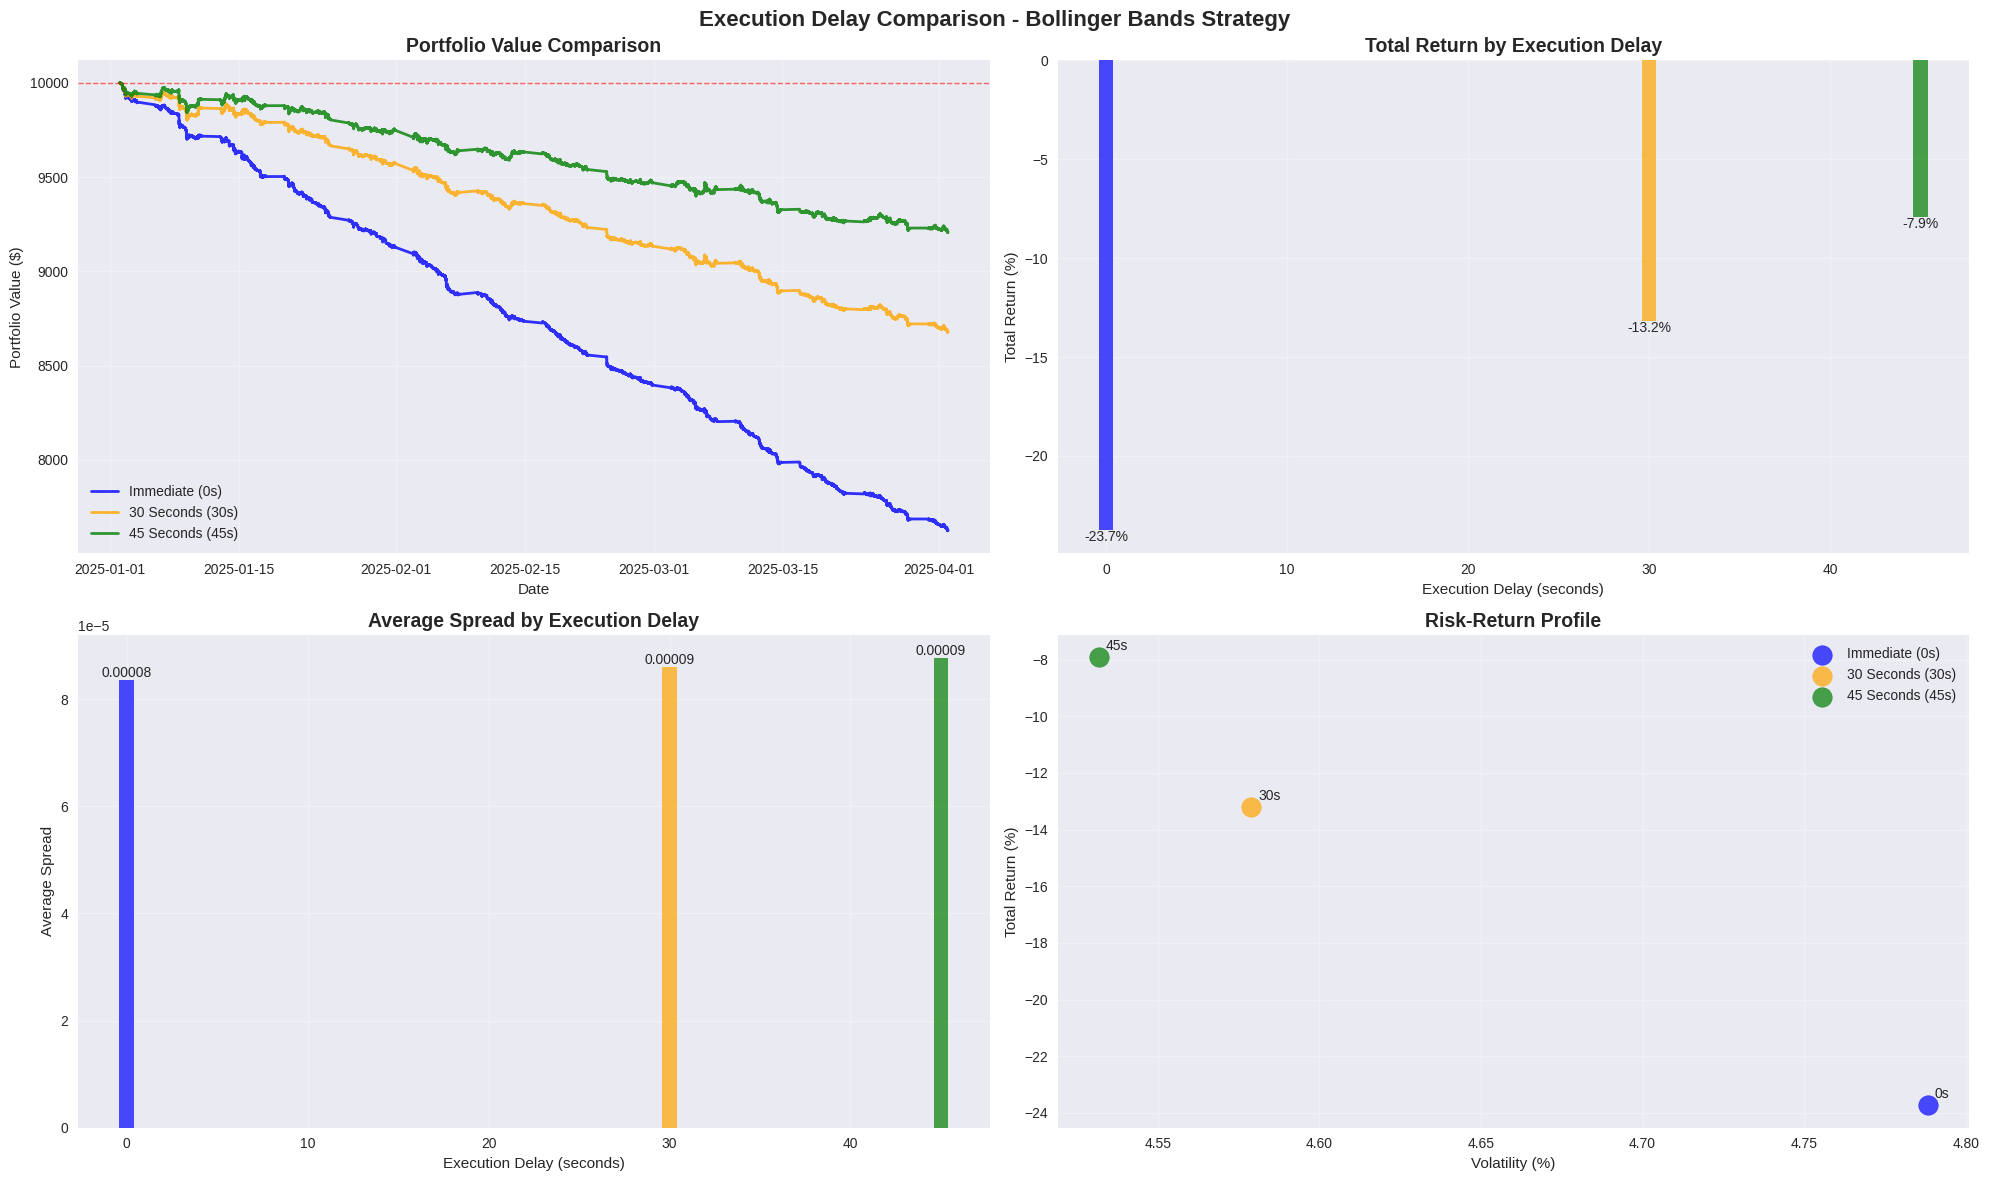

✅ Comparative visualizations created successfully


In [11]:
# ===============================================================================
# 📈 VISUALIZZAZIONE COMPARATIVA
# ===============================================================================

if len(valid_results) > 0:
    print("📈 Creating comparative visualizations...")
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Execution Delay Comparison - Bollinger Bands Strategy', 
                 fontsize=16, fontweight='bold')
    
    # 1. Equity Curves Comparison
    ax1 = axes[0, 0]
    for result in valid_results:
        if 'portfolio_values' in result:
            portfolio_values = result['portfolio_values']
            valid_indices = np.where(portfolio_values > 0)[0]
            if len(valid_indices) > 0:
                dates = ohlc_1min.index[valid_indices]
                values = portfolio_values[valid_indices]
                ax1.plot(dates, values, linewidth=2, alpha=0.8, 
                        label=f"{result['config_name']} ({result['delay_seconds']}s)",
                        color=result['color'])
    
    ax1.axhline(y=INITIAL_CASH, color='red', linestyle='--', alpha=0.6, linewidth=1)
    ax1.set_title('Portfolio Value Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Performance Metrics Comparison
    ax2 = axes[0, 1]
    delays = [r['delay_seconds'] for r in valid_results]
    returns = [r['total_return'] for r in valid_results]
    colors = [r['color'] for r in valid_results]
    
    bars = ax2.bar(delays, returns, color=colors, alpha=0.7)
    ax2.set_title('Total Return by Execution Delay', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Execution Delay (seconds)')
    ax2.set_ylabel('Total Return (%)')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, return_val in zip(bars, returns):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{return_val:.1f}%', ha='center', va='bottom' if height > 0 else 'top')
    
    # 3. Spread Comparison
    ax3 = axes[1, 0]
    spreads = [r['avg_spread'] for r in valid_results]
    bars = ax3.bar(delays, spreads, color=colors, alpha=0.7)
    ax3.set_title('Average Spread by Execution Delay', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Execution Delay (seconds)')
    ax3.set_ylabel('Average Spread')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, spread in zip(bars, spreads):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{spread:.5f}', ha='center', va='bottom')
    
    # 4. Risk-Return Scatter
    ax4 = axes[1, 1]
    volatilities = [r['volatility'] for r in valid_results]
    
    for result in valid_results:
        ax4.scatter(result['volatility'], result['total_return'], 
                   s=200, alpha=0.7, color=result['color'],
                   label=f"{result['config_name']} ({result['delay_seconds']}s)")
        
        # Add annotation
        ax4.annotate(f"{result['delay_seconds']}s", 
                    (result['volatility'], result['total_return']),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    ax4.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Volatility (%)')
    ax4.set_ylabel('Total Return (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Comparative visualizations created successfully")
    
else:
    print("❌ No valid results to visualize")

print("="*80)

In [13]:
# ===============================================================================
# 🏁 SUMMARY FINALE DEL TEST
# ===============================================================================

print("🏁 EXECUTION DELAY TEST COMPLETED")
print("="*60)

if len(valid_results) > 0:
    print(f"✅ Test completato con successo")
    print(f"📊 Configurazioni testate: {len(valid_results)}")
    print(f"🎯 Parametri: MA={TEST_MA_PERIOD}, STD={TEST_STD_DEV}")
    print(f"💰 Capital iniziale: ${INITIAL_CASH:,.0f}")
    
    # Best configuration summary
    best_overall = max(valid_results, key=lambda x: x['sharpe_ratio'])
    print(f"\n🏆 MIGLIORE CONFIGURAZIONE (per Sharpe):")
    print(f"   📈 {best_overall['config_name']} (delay: {best_overall['delay_seconds']}s)")
    print(f"   💰 Return: {best_overall['total_return']:+.2f}%")
    print(f"   ⚖️  Sharpe: {best_overall['sharpe_ratio']:+.3f}")
    print(f"   📏 Spread: {best_overall['avg_spread']:.5f}")
    
    # Data quality check
    total_bars = len(ohlc_1min)
    total_ticks = len(tick_df)
    print(f"\n📊 QUALITÀ DEI DATI:")
    print(f"   🕒 Barre OHLC: {total_bars:,}")
    print(f"   ⚡ Ticks: {total_ticks:,}")
    print(f"   📈 Copertura: {(total_ticks/total_bars):.1f} ticks/bar")
    
    print(f"\n✅ Il test di execution delay è stato completato.")
    print(f"📊 I risultati mostrano l'impatto dei delay sull'esecuzione.")
    print(f"🎯 Utilizzare questi dati per ottimizzare la strategia di trading.")
    
else:
    print("❌ Test fallito - nessun risultato valido")
    print("🔧 Verificare i dati e la configurazione")

print("="*60)
print("🎯 Fine del test sui delay di esecuzione")

🏁 EXECUTION DELAY TEST COMPLETED
✅ Test completato con successo
📊 Configurazioni testate: 3
🎯 Parametri: MA=120, STD=2
💰 Capital iniziale: $10,000

🏆 MIGLIORE CONFIGURAZIONE (per Sharpe):
   📈 45 Seconds (delay: 45s)
   💰 Return: -7.91%
   ⚖️  Sharpe: -1.746
   📏 Spread: 0.00009

📊 QUALITÀ DEI DATI:
   🕒 Barre OHLC: 91,984
   ⚡ Ticks: 5,572,578
   📈 Copertura: 60.6 ticks/bar

✅ Il test di execution delay è stato completato.
📊 I risultati mostrano l'impatto dei delay sull'esecuzione.
🎯 Utilizzare questi dati per ottimizzare la strategia di trading.
🎯 Fine del test sui delay di esecuzione
